# Prompt Tuning



In [1]:
#@title Colab-specific setup
#@markdown This will ask for you to log into Google Drive.
#@markdown Click on the link and copy over your access token.

import torch
colab = 'google.colab' in str(get_ipython())

if colab:
    !nvidia-smi
    gpu_type = torch.cuda.get_device_name(0)
    if gpu_type != 'Tesla T4':
        raise ValueError("Highly advised to use a T4.")

# Setup for Colab only
if colab:
    !pip install git+https://github.com/finetuneanon/transformers@gpt-neo-localattention3
    !pip install git+https://github.com/corolla-johnson/mkultra.git#egg=mkultra --log PIP_LOG
    !pip install gdown
    !pip install datasets
    !pip install tqdm

    # Add word wrapping to outputs
    from IPython.display import HTML, display
    def set_css():
      display(HTML('''
      <style>
        pre {
            white-space: pre-wrap;
        }
      </style>
      '''))
    get_ipython().events.register('pre_run_cell', set_css)

# If on Colab, mount your Google Drive first!
if colab:
    from google.colab import drive
    drive.mount('/content/drive')


Sun Jul 11 07:09:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#@title (Optional) Grab text from Project Gutenberg
#@markdown We'll be using "Alice's Adventures in Wonderland" by Lewis Caroll.
import requests, re
data_str = requests.get("https://www.gutenberg.org/files/11/11-0.txt").content.decode("utf-8")

# Do a little cleanup
clean_data_str = data_str

def regex_replace(str, regex, group, replacement):
    pat = re.compile(regex)
    while True:
        m = pat.search(str)
        if m is not None:
            str = str[:m.start(group)] + replacement + str[m.end(group):]
        else:
            break
    return str

# Remove carriage returns
clean_data_str = regex_replace(clean_data_str, r"\r", 0, "")

# Replace single newlines with spaces
clean_data_str = regex_replace(clean_data_str, r"\S(\n)\S", 1, " ")

# Remove left quotes
clean_data_str = regex_replace(clean_data_str, r"\u201C", 0, '"')

# Remove right quotes
clean_data_str = regex_replace(clean_data_str, r"\u201D", 0, '"')

# Remove italics
clean_data_str = regex_replace(clean_data_str, r"_", 0, '')

# Remove header and footer
clean_data_str = clean_data_str[1434:-18595]

print(clean_data_str)

with open("alice.txt", "w") as file:
    file.write(clean_data_str)


CHAPTER I. Down the Rabbit-Hole


Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, "and what is the use of a book," thought Alice "without pictures or conversations?"

So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.

There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, "Oh dear! Oh dear! I shall be late!" (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waist

In [5]:
#@title Load tokenizer
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

In [6]:
#-----------------------#
#  Training Parameters  #
#-----------------------#

# Use a string to set the initial value of the soft prompt.
# Be aware of the number of tokens.
initial_prompt = "A surreal children's fantasy story set in a subterranean world populated by peculiar anthropomorphic creatures.\n"

print(f"Initial prompt length: {len(tokenizer.encode(initial_prompt))} tokens")

# Decide the length of your training blocks in tokens.
# Safe sizes for gpt-neo-2.7B-halved:
#  - 700 on a Colab T4 (16GB)
#  - 400 on a Colab K80 (12GB)
#  - 32 on a GTX1080 (8GB)
# If it seems a bit small, don't worry!
# Soft prompts can be moved forward in context for the best effect.
block_size = 700

# Name your soft prompt project.
sp_name = 'alice-cyclic-dropout-2'

# What's the name of model you'll be using?
# e.g. gpt2, gpt2-large, gpt-neo-2.7B
# (This will be added to the project directory and soft prompt name)
model_name = 'gpt2'

# Specify the model directory or huggingface name.
model_dir = 'gpt2'

# The above model_dir will download GPT2 1.5B from Huggingface as a baseline.
# It is recommended to use finetuneanon's FP16 fork of gpt-neo-2.7B, which can be downloaded from this magnet link:
# magnet:?xt=urn:btih:f50bb4e259d2f96aa9151443950b0d2b899a097c&dn=gpt-neo-2.7B-halved&tr=http%3A%2F%2Fopenbittorrent.com%3A80%2Fannounce&tr=http%3A%2F%2Ft.nyaatracker.com%3A80%2Fannounce&tr=udp%3A%2F%2Fopen.stealth.si%3A80%2Fannounce
# Once you've saved it to your local machine, create a 'models' folder in your Google Drive and upload it there,
# then uncomment the following:
#model_dir = "/content/drive/MyDrive/models/gpt-neo-2.7B-halved/"

# Should be 'gpt2' or 'gpt-neo'.
model_type = 'gpt2'

# Specify the path to the text file used for training.
text_path = "alice.txt"
# You can also use something uploaded to your Google Drive, e.g.
#text_path = "/content/drive/MyDrive/datasets/nm_burning_chrome.txt"

# Specify the project directory.
project_dir = f"/content/drive/MyDrive/soft_prompts/{sp_name}-{model_name}/"

# Checkpoint interval in steps.
checkpoint_interval = 20

# Evaluation interval in steps.
eval_interval = 5

# How many blocks to use for evaluation.
eval_blocks = 16

# Adafactor hyperparameters
optimizer_params = {
    # Fixed learning rate, recommend 1e-4 to 1e-3
    "lr": 2e-4,
    
    # 1st momentum, recommend 0
    "beta1": 0.0,

    # 2nd momentum decay schedule, recommend -0.3 (lower is slower)
    "decay_rate": -0.8,

    # Weight decay, recommend 1e-5
    "weight_decay": 0.1,
    
    # Update scaling, recommend False
    "scale_parameter": False,
    
    # Built-in LR scheduler, recommend False
    "relative_step": False
    }

# LR scheduler parameters
scheduler_params = {
    "num_warmup_steps": 10,
    "num_cycles": 8,
    "num_training_steps": 400
}

# (Use these for GPT-Neo)
#scheduler_params = {
#    "num_warmup_steps": 10,
#    "num_cycles": 4,
#    "num_training_steps": 240
#}

base_acc_steps = 16
acc_doubling_rate = 0
plateau_steps = 0

Initial prompt length: 20 tokens


In [7]:
#@title Load model

from mkultra.tuning import GPTNeoPromptTuningLM, GPT2PromptTuningLM

if 'model' not in globals():
    if model_type == 'gpt2':
        model = GPT2PromptTuningLM.from_pretrained(model_dir).half().to("cuda")
    elif model_type == 'gpt-neo':
        model = GPTNeoPromptTuningLM.from_pretrained(model_dir).half().to("cuda")
    else:
        raise "Invalid model type"

In [8]:
#@title Initialize project
#@markdown This will load the latest checkpoint if the project directory already exists.

from mkultra.soft_prompt import SoftPrompt
from transformers import Adafactor
import os

filename_for_checkpoint = lambda step: f"{sp_name}-{model_name}-step-{step}.json"
loaded_sp = None
project_files = None

# Look for existing project directory
try:
    os.makedirs(project_dir)
    print(f"Created project directory at {project_dir}")
except FileExistsError:
    print(f"Found project directory at {project_dir}")

# Look for existing checkpoints
project_files = os.listdir(project_dir)
if project_files is not None:
    checkpoint_files = [check_file for check_file in project_files if ('-step-' in check_file) ]

    if len(checkpoint_files) > 0:
        highest_step = max([ int(check_file[check_file.rfind('-step-')+6:-5]) for check_file in checkpoint_files ])
        loaded_sp = SoftPrompt.from_file( os.path.join(project_dir, filename_for_checkpoint(highest_step)) )
        print(f"Loading latest checkpoint: {highest_step}")
    else:
        print("No checkpoints found")

Created project directory at /content/drive/MyDrive/soft_prompts/alice-cyclic-dropout-2-gpt2-large/
No checkpoints found


In [9]:
#@title Process dataset
#@markdown This will load an existing set
#@markdown of tokens if present in the project directory.

import json
import math

text_tokenized = None
tokens_path = os.path.join(project_dir,"tokens.json")

# See if we already have a tokens file
try:
    with open(tokens_path, 'r', encoding='utf-8') as file:
        text_tokenized = json.load(file)
        print("Loaded existing tokens.json file")

except FileNotFoundError:
    print("No tokens.json exists, creating it...")

# If not, make one now
if text_tokenized is None:

    with open(text_path, 'r', encoding='utf-8') as file:
        text = file.read()
    text_tokenized = tokenizer.encode(text)
    
    with open(tokens_path, 'x', encoding='utf-8') as file:
        json.dump(text_tokenized, file)

text_length = len(text_tokenized)
num_blocks = math.ceil(text_length/block_size)

print(f"Length of text: {len(text_tokenized)} tokens")
print(f"Number of blocks: {num_blocks}, each {block_size} tokens")

# Partition tokens into blocks
blocks = list()
for block_num in range(num_blocks):
    start = block_num * block_size
    end = min(start + block_size, text_length)
    blocks.append( text_tokenized[start:end] )

block_order_path = os.path.join(project_dir, "block_order.json")

# See if we already have a block_order file
try:
    with open(block_order_path, 'r', encoding='utf-8') as file:
        block_order = json.load(file)
        print("Loaded existing block_order.json file")

except FileNotFoundError:
    print("No block_order.json exists, creating it...")
    block_order = [*range(num_blocks)]

    with open(block_order_path, 'x', encoding='utf-8') as file:
        json.dump(block_order, file)

Token indices sequence length is longer than the specified maximum sequence length for this model (38520 > 1024). Running this sequence through the model will result in indexing errors


No tokens.json exists, creating it...
Length of text: 38520 tokens
Number of blocks: 56, each 700 tokens
No block_order.json exists, creating it...


In [10]:
#@title Initialize soft prompt in model
#@markdown If a checkpoint is present, use that.
if loaded_sp is None:
    initial_sp = SoftPrompt.from_string(initial_prompt, model, tokenizer)
    print(f"Initial prompt length: {len(initial_sp)}")
    model.set_soft_prompt(initial_sp)

    sp_step = 0
    eval_loss = 100
else:
    model.set_soft_prompt(loaded_sp)
    sp_step = loaded_sp._metadata['step']
    eval_loss = loaded_sp._metadata['loss']

Initial prompt length: 20


In [11]:
# Configure number of steps to train for.
# One step is (acc_steps) forward passes.
num_training_steps = scheduler_params['num_training_steps']

In [12]:
from transformers import AdamW, Adafactor
import transformers

# Feed soft params to optimizer
optimizer_params['params'] = [model.get_soft_params()]
optimizer = Adafactor(**optimizer_params)
optimizer.state['step'] = sp_step

scheduler_params['optimizer'] = optimizer
scheduler = transformers.get_cosine_with_hard_restarts_schedule_with_warmup(**scheduler_params)

In [13]:
#@title Train the soft prompt

from tqdm.notebook import tqdm
import random
import torch
import math

torch.cuda.empty_cache()
loss_log_path = os.path.join(project_dir,"loss_log.csv")
bar = tqdm(total=num_training_steps)
optimizer.state['step'] = sp_step
evals_since_last_improvement = 0
best_eval = float('inf')

# Fix eval order
eval_order = [*range(num_blocks)]
random.seed(1234)
random.shuffle(eval_order)

# Function for gradient accumulation scheduling
def get_acc_steps(sp_step):
    if acc_doubling_rate != 0:
        return round(base_acc_steps * math.pow(2, (sp_step / acc_doubling_rate)))
    else:
        return base_acc_steps

for session_step in range(num_training_steps):
      model.train()

      acc_steps = get_acc_steps(sp_step)

      for i in range(acc_steps):
          idx = (sp_step*acc_steps + i) % num_blocks

          # Shuffle blocks every epoch
          if idx == 0:
              random.shuffle(block_order)
              with open(block_order_path, 'w', encoding='utf-8') as file:
                  json.dump(block_order, file)

          block = blocks[block_order[idx]]

          input_ids = torch.LongTensor(block).unsqueeze(0).cuda().detach()
          
          # Forward pass and optimize
          outputs = model(input_ids=input_ids, labels=input_ids)
          loss = outputs.loss
          loss.backward()

          instant_loss = loss.item()
          if math.isnan(instant_loss):
              torch.cuda.empty_cache()
              raise KeyboardInterrupt

          # Discard tensor that was moved to GPU
          del input_ids
          torch.cuda.empty_cache()

      # Accumulate gradients
      optimizer.step()
      lr = optimizer.param_groups[0]["lr"]
      scheduler.step()
      optimizer.zero_grad()

      if math.isnan(instant_loss):
          torch.cuda.empty_cache()
          raise KeyboardInterrupt

      # Evaluate model and plot loss
      if sp_step%eval_interval == 0:
          model.eval()
          torch.cuda.empty_cache()
          eval_loss = 0

          with torch.no_grad():
              for eval_step in range(eval_blocks):
                  block = blocks[eval_order[eval_step]]
                  input_ids = torch.LongTensor(block).unsqueeze(0).cuda().detach()
                  eval_loss += model(input_ids=input_ids, labels=input_ids).loss.item()
                  
                  # Discard tensor that was moved to GPU
                  del input_ids
                  torch.cuda.empty_cache()

          eval_loss /= eval_blocks

          with open(loss_log_path, 'a', encoding='utf-8') as file:
              file.write(f"{sp_step},{eval_loss}\n")
          
          # Stop if loss has plateaued
          if plateau_steps != 0:
              if eval_loss < best_eval:
                  best_eval = eval_loss
                  evals_since_last_improvement = 0
              else:
                  evals_since_last_improvement += 1
              if evals_since_last_improvement > plateau_steps:
                  print(f"No improvement for {plateau_steps} evals")
                  break

      # Save checkpoint every so often
      if sp_step%checkpoint_interval == 0:
          sp = SoftPrompt.from_tuning_model(model,
              {"name" : sp_name + f"-step-{sp_step}",
               "step"  : sp_step,
               "loss"  : eval_loss})
          sp.to_file( os.path.join( project_dir,filename_for_checkpoint(sp_step) ) )

      bar.set_postfix({
          "Model Step" : sp_step,
          "Eval Loss"  : "{el:.5f}".format(el=eval_loss),
          "Acc Steps"  : acc_steps,
          "LR"         : lr
      })
      bar.update(1)
      sp_step += 1

# Save a checkpoint once done
sp = SoftPrompt.from_tuning_model(model,
    {"name"  : sp_name + f"-step-{sp_step}",
     "step"  : sp_step,
     "loss"  : eval_loss})
sp.to_file( os.path.join( project_dir,filename_for_checkpoint(sp_step) ) )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:562: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg_sq_row.mul_(beta2t).add_(1.0 - beta2t, update.mean(dim=-1))


In [14]:
#@title Flush memory after interrupting training
#@markdown This will *hopefully* prevent a CUDA out-of-memory error.
try:
  del input_ids
except Exception:
  pass
torch.cuda.empty_cache()

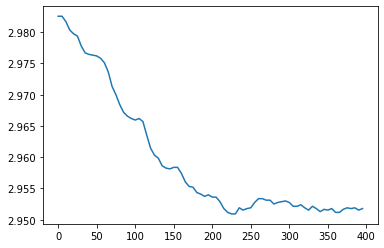

In [19]:
# Plot loss
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import numpy as np

fname2 = cbook.get_sample_data(loss_log_path, asfileobj=False)
with cbook.get_sample_data(loss_log_path) as file:
    array = np.loadtxt(file, delimiter=",")

fig = plt.figure()
plt.plot(array[:, 0], array[:, 1])

In [46]:
# Try generating with your model
model.eval()

# Restore soft prompt from checkpoint
# (Use above graph to find a good stopping point and check project directory for valid checkpoints)
sp = SoftPrompt.from_file( os.path.join(project_dir, filename_for_checkpoint(400)) )
model.set_soft_prompt(sp)

test = "Alice sipped her tea as the white rabbit gloated about his vast collection of pocket watches"

call = tokenizer(test, return_tensors="pt").input_ids.cuda()

basic_output = model.generate(
    input_ids=call,
    do_sample=True,
    min_length=call.shape[-1] + 200,
    max_length=call.shape[-1] + 200,
    temperature=1.0,
    tfs = 0.9,
    repetition_penalty = 3.0,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(basic_output[0]))

Alice sipped her tea as the white rabbit gloated about his vast collection of pocket watches.
"Not so, we'll be looking for you soon," she said quietly to herself. "Just in time."She went into a deep-rooted library and found bookshelves full outspread with stacks containing hundreds upon thousands more that had been lost when an unknown intruder entered them from nowhere. This was before they were sealed shut by their own owners—that is how this strange place called The Cave Of Light really became known later on until all our stories began repeating themselves; it seems almost impossible now not only because no one knew what happened but also just like some people might have assumed there would never come another such cave left open every day after sunset…A dark skylit garden lay bare beside Alice's bedroom at nightfall: huge tables sat flush against each other waiting patiently where nothing could break through or leave anything behind which contained bits enoughTo draw breath must le

In [49]:
model.eval()

# Purge soft prompt for comparison.
model.initialize_soft_prompt(n_tokens=1)

test = "Alice sipped her tea as the white rabbit gloated about his vast collection of pocket watches"

call = tokenizer(test, return_tensors="pt").input_ids.cuda()

basic_output = model.generate(
    input_ids=call,
    do_sample=True,
    min_length=call.shape[-1] + 200,
    max_length=call.shape[-1] + 200,
    temperature=1.0,
    tfs = 0.9,
    repetition_penalty = 3.0,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(basic_output[0]))

Alice sipped her tea as the white rabbit gloated about his vast collection of pocket watches.
"All right, I'll see you in a few hours," Alice said quietly and took off from where she'd left him to sit for coffee at least once before returning back home with Jack's gold watch on display outside their small dining room table near us again just below our living rooms window that held three separate times large pieces: two black-and -white diamonds; one silver ring which looked like it belonged within an octagonal glass case over some kind other than quartz or iron... well so many things were different (I was quite sure what they might be! This is not my first time hearing such something!) So long ago did he forget anything more important besides watching me while we sat there alone staring into each others eyes? There must have been someone out here who heard all this talking around them because when everyone else got up after work most people didn't bother asking anyone why Silly Puffs h